In [8]:
# !pip install randominfo
# !pip install russian_names
# !pip install faker

# !mkdir genered_pass_folder fonts

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
# import pytesseract
from random import choice
from pathlib import Path
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from generator import pass_gen
from word_detector import detect, sort_line
from functions import adaptive_gaussian_binarization
from model import build_model, split_data, exponential_lr

In [13]:
n = 500 - len(os.listdir('genered_pass_folder')) # При необходимоси увеличим число фото до заданного объема

for _ in range(n): # Сгенерируем необходимые для обучения фото пасспортов
    img = pass_gen(img_save=True)

In [30]:
# Path to the data directory
data_dir = Path("./genered_pass_folder/")

# Get lists of all images, labels and characters
image_names = list(map(str, list(data_dir.glob("*.jpg"))))
images = [cv2.imread(img_nm) for img_nm in image_names]

labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in image_names]

characters = set(char for label in labels for char in label)
characters = sorted(list(characters))
max_len = max([len(label) for label in labels])

In [15]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [16]:
model = build_model(char_to_num)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 600, 903, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 600, 903, 32  320         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 pool1 (MaxPooling2D)           (None, 300, 451, 32  0           ['Conv1[0][0]']                  
                                )                                                      

In [17]:
def encode_single_sample(img_path:str,
                         label:str)->dict:
    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [903, 600])

    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])

    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    
    # 7. Return a dict as our model is expecting two inputs

    return {'image':img, 'label':label}

In [18]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(image_names), np.array(labels))

In [19]:
most_freq_len = pd.Series([len(label) for label in labels]).value_counts().index[0]

In [20]:
batch_size = 3

# Для тестирования модели необходимо было отобрать пасспорта с ФИО одинакой длины ( значимое ограничение )
labels_for_train = [idx for idx, label in enumerate(y_train) if len(label)==most_freq_len] # наиболее частая длина ФИО  
labels_for_val = [idx for idx, label in enumerate(y_valid) if len(label)==most_freq_len]

# Обучающий датасет
train_dataset = tf.data.Dataset.from_tensor_slices((x_train[labels_for_train], 
                                                    y_train[labels_for_train]))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
# Датасет валидации
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid[labels_for_val], 
                                                         y_valid[labels_for_val]))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

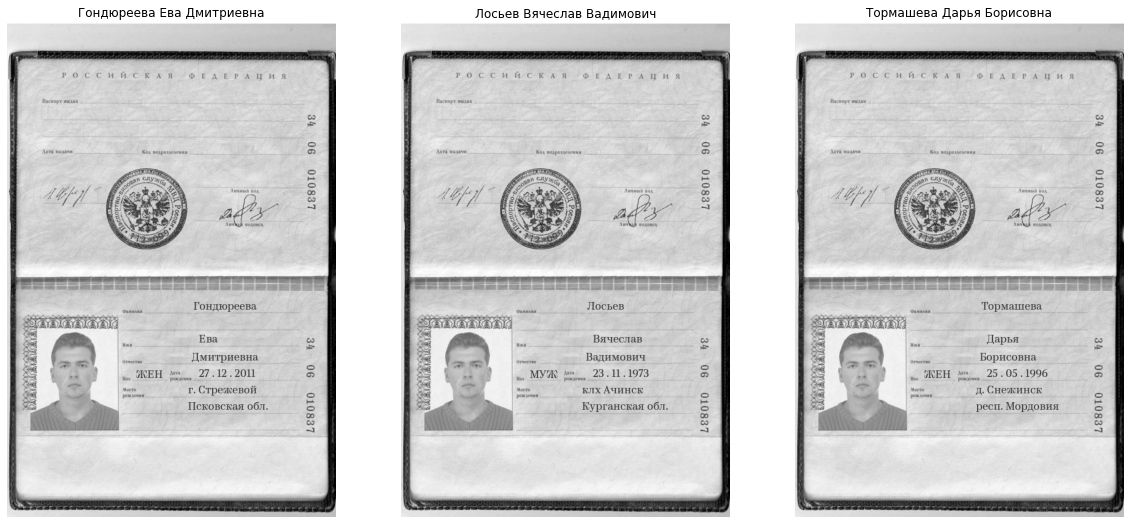

In [22]:
_, ax = plt.subplots(1, 3, figsize=(20, 20)) # визуализируем обучающие данные
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
   
    for i in range(3):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i].imshow(img[:, :, 0].T, cmap="gray")
        ax[i].set_title(label)
        ax[i].axis("off")
plt.show()

Learning rate schedule: 5e-05 to 5e-05 to 2.55e-06


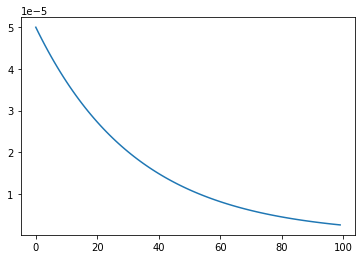

In [23]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(100)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

Обучение модели

In [ ]:
epochs = 50


early_stopping = keras.callbacks.EarlyStopping( monitor="val_loss",       # защита от переобучения модели
                                                patience=20,
                                                restore_best_weights=True)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr,    # постепенное снижение lr - оптимизация градиентного спуска 
                                                                          # на поздних эпохах 
                                                       verbose=True)


# Train the model
history = model.fit( train_dataset,
                     validation_data=validation_dataset,
                     epochs=epochs,
                     callbacks=[lr_callback, early_stopping])

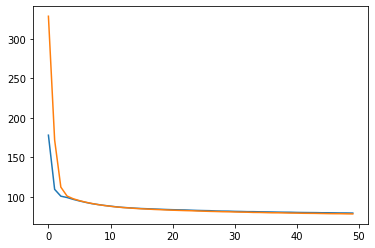

In [25]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

Предскажем с помощью обученной модели ФИО с фото пасспортов  

In [33]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

pred_texts = []
orig_texts = []

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len]

    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in train_dataset.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts.append(decode_batch_predictions(preds)) # Полученные предсказания

    
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label) # Истинные ФИО с изображений

1/1 [==============================] - 1s 1s/step


In [35]:
pred_texts # результат предсказания на тренировочных данных - удручает

[['[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
  '[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
  '[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]']]

# Вырежем необходимый для обучения текст с изображений

Воспользуемся возможностями модуля **word_detector**

In [ ]:
img_name = choice(os.listdir('DataForOCR/'))
img_path = f'DataForOCR/{img_name}' # Случайно выбранное изображение пасспорта

img = adaptive_gaussian_binarization(cv2.imread(img_path), block_size=31) 

detections = detect(np.array(img),
                    kernel_size=31,
                    sigma=20,
                    theta=7,
                    min_area=100)

line = sort_line(detections)[0]

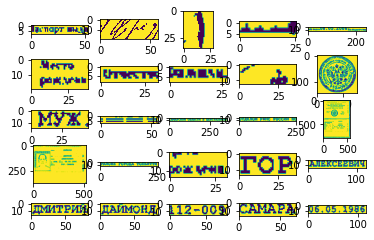

<Figure size 1440x1440 with 0 Axes>

In [ ]:
n = int(len(line)**0.5)

fig, ax = plt.subplots(n,n)
fig  = plt.figure(figsize=(20,20))

for idx, im in enumerate(line):
    try:
        ax[idx//n, idx%n].imshow(im.img)
    except:
        pass

Обратимся к возможностям модуля **pytesseract**

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe' # путь к файлу tesseract.exe

In [ ]:
img_name = choice(os.listdir('DataForOCR/'))
img_path = f'DataForOCR/{img_name}' # Случайно выбранное изображение пасспорта

img = cv2.imread(img_path)
# img = adaptive_gaussian_binarization(img, block_size=51) # Предобработка в данном случае снижает качество обнаружения текста 

hImg, wImg, _   = img.shape


boxes = pytesseract.image_to_boxes(img, 
                                   lang='rus',
                                   config='--oem 3 --psm 4')

char_list = []

for box in boxes.splitlines():

    box = box.split(' ')
    y,x,h,w = list(map(int, box[1:5])) # получаем необходимые для выделения буквы координаты

    cv2.rectangle(img, (y, hImg-x), (h,hImg-w), (0,255,0),1)

    
    char = img[y+1:h-1, hImg-w+1:hImg-x-1] # выделяем изображение буквы, согласно полученным координатам, с отступом в 1 пиксель
    cH, cW, _ = char.shape

    
    if (sum(char.shape[:2])/2 <= 8) or (0 in char.shape): # отфильтровываем неинформативные изображения
        continue

    char_list.append(char) # составляем список изображений букв

In [37]:
n = int(len(char_list)**0.5)

fig, ax = plt.subplots(n,n)
fig  = plt.figure(figsize=(20,20))

for idx, char in enumerate(char_list):
    try:
        ax[idx//n, idx%n].imshow(char)
    except:
        pass